In [2]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
import random

import torch

import scipy.stats as stat
from tqdm.notebook import tqdm

In [3]:
def load_image(fname):
    img = np.mean(imread(fname), axis=2)  # Grayscale
    img = (img[:, :]) / 255.0
    return 1 - img  # black = 1, white = 0

def cloud_transform(image, n_samples=1000):
    image = image > 0.1
    samples = np.vstack([np.where(image)[1] / image.shape[1],
                         1 - np.where(image)[0] / image.shape[0]]).T
    samples = samples - samples.mean(axis=0)
    samples = samples * 2
    # add a little bit of noise to avoid the sampling patterns
    samples += np.random.randn(samples.shape[0], 2) * 2e-3
    samples = samples[random.sample([i for i in range(len(samples))], n_samples)]
    return samples

In [4]:
obelix = load_image('obelix.jpg')
asterix = load_image('asterix.jpg')
#plt.imshow(obelix,cmap='Greys')
#plt.axis('off')

/tmp/ipykernel_1664638/3075584923.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = np.mean(imread(fname), axis=2)  # Grayscale


## 0/ Define source and target distributions

In [5]:
target = cloud_transform(obelix, n_samples=1000)
source = cloud_transform(asterix, n_samples=1000)

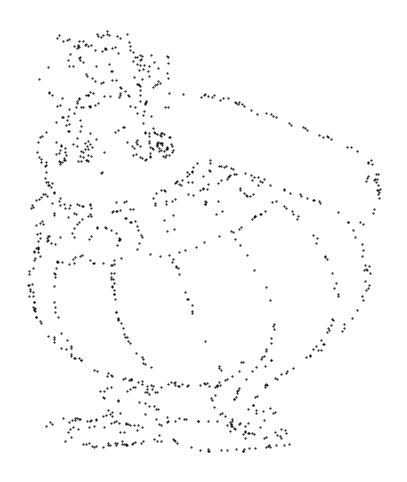

In [5]:
plt.figure(figsize=(5,6))
plt.scatter(target[:,0], target[:,1],marker='.',c='k',s=1)
plt.axis('off')
plt.show()

## 1/ General framework

The goal of flow matching is to transform a source distribution $p_0$ into the target distribution $p_1$. To do so, we consider a probability path $(p_t)_{t\in[0,1]}$ between $p_0$ and $p_1$. We also define a time-dependent flow $\Psi: [0,1] \times \mathbb{R}^d \rightarrow \mathbb{R}^d$ that pushes $p_0$ to $p_t$: $p_t=[\Psi_t]*p_0$

The flow is defined with an Ordinary Differential Equation (ODE):
$\frac{d}{d t} \Psi_t(x) & =v_t(\Psi_t(x))$

Marginal distribution:\
$p_t(x)=\int p_t\left(x \mid z\right) q\left(z\right) d z$ \
Velocity field:\
$u_t(x)=\int u_t\left(x \mid z\right) \frac{p_t\left(x \mid z\right) q\left(z\right)}{p_t(x)} d z$

## 2/ Flow matching from gaussian

Independent coupling $p_t(x|z=(x_0,x_1))=\mathcal{N}(x_0(1-t)+tx_1, \sigma^2)$

In [ ]:
def cond_ut(x0, x1, t, sigma_min=0.01):
    return (x1-x0)

def flow(x, source, target, t, n_samples=100, sigma_min=0.01):
    s = np.random.randn(100,2)*0.2 #source[random.sample([i for i in range(len(source))], n_samples)]
    d = np.random.randn(100,2)*0.7+4 #target[random.sample([i for i in range(len(target))], n_samples)]*
    weight = np.exp(-((x-(s*(1-t)+t*d))**2).sum(axis=1)/((2*sigma_min)**2))
    weight = weight / np.sum(weight, axis=0, keepdims=True)
    ut_cond = cond_ut(x, d, t)
    flow = np.sum(weight[:, None] * ut_cond, axis=0)
    return flow 


def euler_sample(source, target, timesteps):
    x = source
    res = [source]
    for i in range(len(timesteps)-1):
        x = x + flow(x, source, target, timesteps[i]) * (timesteps[i+1]-timesteps[i])
        res.append(x)
    return np.array(res)

Conical flow $p_t(x|z=x_1)=\mathcal{N}(tx_1, (1+t(1-\sigma))^2)$

In [127]:
def cond_ut(x, x1, t, sigma_min):
    return (x1-x*(1-sigma_min))/(1-t*(1-sigma_min))

def flow(x, source, target, t, sigma_min):
    s = np.random.randn(100,2) #source[random.sample([i for i in range(len(source))], n_samples)]
    d = target #np.random.randn(100,2)*0.7+4 #target[random.sample([i for i in range(len(target))], n_samples)]*
    flows = []
    for i in range(x.shape[0]):
        weight = np.exp(-((x[i]-t*d)**2).sum(axis=1)/(2*(1-(1-sigma_min)*t)**2))
        weight = weight / np.sum(weight, axis=0, keepdims=True)
        ut_cond = cond_ut(x[i], d, t, sigma_min)
        print(ut_cond.shape)
        flows.append(np.sum(ut_cond*weight[:, None], axis=0))
        print(flows[-1].shape)
    return np.array(flows)

def euler_sample(source, target, timesteps, sigma_min):
    x = source
    res = [source]
    for i in range(len(timesteps)-1):
        flows = flow(x, source, target, timesteps[i], sigma_min) 
        x = x + flows * (timesteps[i+1]-timesteps[i])
        res.append(x)
    return np.array(res)

In [128]:
#source=np.random.randn(1000, 2) 
source = np.random.randn(100,2)
target = np.random.randn(50,2)*0.3+3
timesteps = np.linspace(0, 1, 100)
res = euler_sample(source, target, timesteps, sigma_min=0.001)

(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)
(50, 2)
(2,)

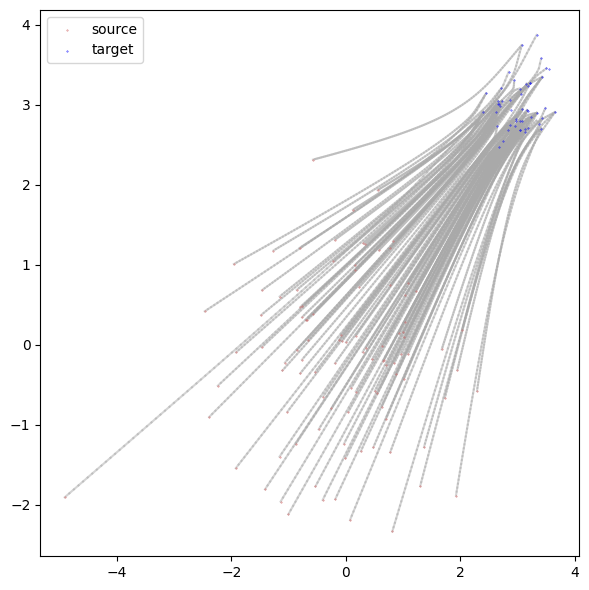

In [129]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

for i in range(len(timesteps)-1):
    ax.plot([res[i,:,0],res[i+1,:,0]],[res[i,:,1],res[i+1,:,1]],c='darkgrey',alpha=0.5)

ax.scatter(*source.T,c='indianred',s=0.1,label='source',zorder=2)
ax.scatter(*target.T,c='b',s=0.1, label='target',zorder=3)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

## 3/ Flow matching from data distribution